# <center> Обучение с учителем. Регрессия
## <center> Предсказываем индивидуальные медицинские расходы граждан, оплачиваемые медицинской страховкой

In [1]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки
%matplotlib inline
plt.style.use('seaborn')

C:\Users\79265\AppData\Local\Temp\ipykernel_6944\1094269666.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


### Знакомство с данными

In [2]:
data = pd.read_csv('data/insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
# Размер таблицы
print(data.shape)

(1338, 7)


In [4]:
# информация о пропусках
display(data.isnull().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [5]:
# типы данных
display(data.dtypes)

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

## <center> Итерация №1
На первой итерации мы должны прийти к выводу - решаема ли задача. Может ли модель получить базовое качество (baseline). Для этого мы проводим небольшое исследование данных, базовую предобработку и строим простую модель, без подбора параметров.

### Исследование данных

In [6]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [7]:
data.describe(include='object')

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


In [8]:
#Создаем копию данных для облегчения работы с изменениями в таблице
df = data.copy()

Проведем небольшое исследование зависимости целевого признака charges от числовых признаков.

In [9]:
#выделяем имена числовых признаков в виде списка для удобства дальнейшей работы
types = df.dtypes
num_features = list(types[(types != 'object')].index)
num_features

['age', 'bmi', 'children', 'charges']

Для каждого числового признака построим гистограмму признаки и диаграмму рассеяния, иллюстрирующую зависимость целевого признака от каждого из факторов. Дополнительно поверх диаграммы рассеяния построим уравнение линейной регрессии.

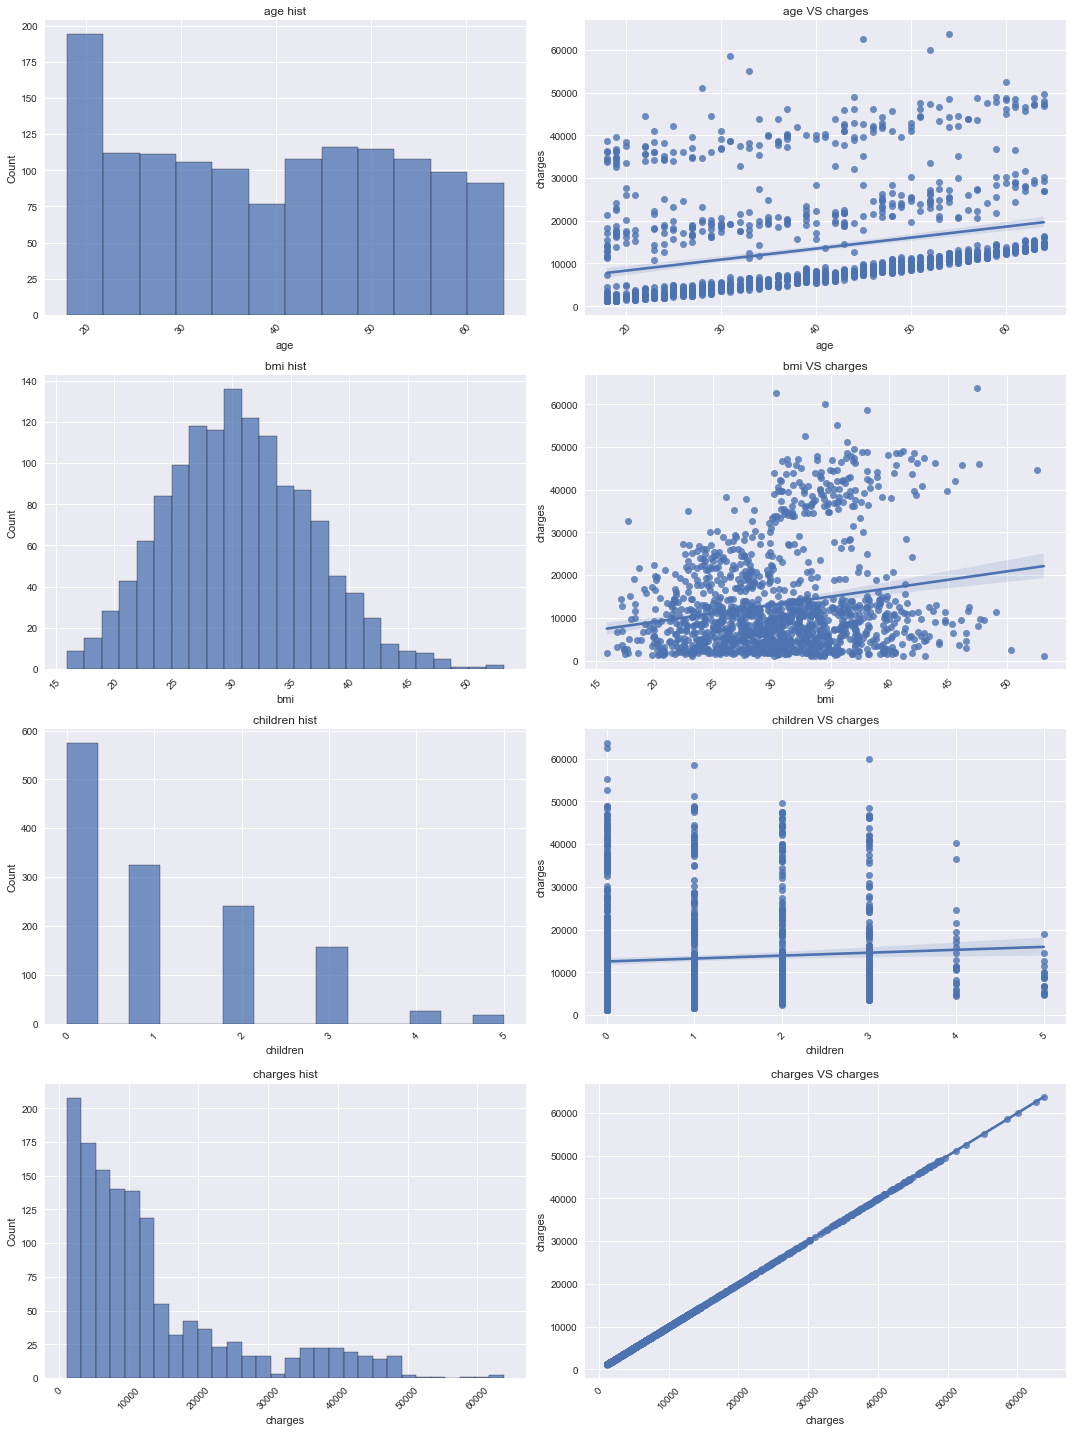

In [10]:
n = len(num_features) #количество числовых признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 20)) # фигура + n х 2 координатных плоскостей
#Создаем цикл для всех признаков из списка числовых признаков
for i, feature in enumerate(num_features): #i- индекс, feature - название признака в таблице
    #Строим гистограмму распределения признака 
    histplot = sns.histplot(data=df, x=feature, ax=axes[i][0])
    #Добавляем подпись графику
    histplot.set_title('{} hist'.format(feature))
    #Добавляем поворот отметок на оси абсцисс
    histplot.xaxis.set_tick_params(rotation=45)
    #Строим диаграмму рассеяния + линейную регрессию
    regplot = sns.regplot(data=df, x=feature, y='charges', ax=axes[i][1])
    #Добавляем подпись графику
    regplot.set_title('{} VS charges'.format(feature));
    #Добавляем поворот отметок на оси абсцисс
    regplot.xaxis.set_tick_params(rotation=45)
plt.tight_layout() #выравнивание графиков

Строим тепловую карту для корреляционной матрицы, чтобы оценить мультиколлинеарную зависимость и линейную взаимосвязь между факторами и целевым признаком (charges)

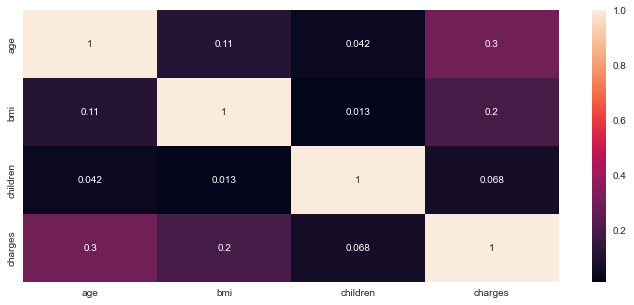

In [11]:
#строим тепловую карту корреляций
fig = plt.figure(figsize=(12, 5))
sns.heatmap(df.corr(), annot=True);

### Подготовка данных

In [18]:
df['smoker'] = df['smoker'].apply(lambda x: 1 if x == 'yes' else 0)
df['sex'] = df['sex'].apply(lambda x: 1 if x == 'male' else 0)

In [22]:
df = pd.get_dummies(df)
df.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0,0,0,1
1,18,1,33.770,1,0,1725.55230,0,0,1,0
2,28,1,33.000,3,0,4449.46200,0,0,1,0
3,33,1,22.705,0,0,21984.47061,0,1,0,0
4,32,1,28.880,0,0,3866.85520,0,1,0,0


Разделим набор данных на матрицу наблюдений X (таблица из объектов и их признаков) и столбец правильных ответов y

In [26]:
#X - матрица наблюдений, y - столбец правильных ответов
features = df.drop('charges', axis=1).columns
X, y = df[features], df['charges']

In [23]:
#X - матрица наблюдений, y - столбец правильных ответов
# X = df.drop('charges', axis=1)
# y = df['charges']

Разделяем всю выборку на тренировочную и тестовую в соотношении 80/20.

На тренировочной выборке будем обучать модели, а на тестовой проверять их качество.

Задание 6.1. Чему равно количество наблюдений в тестовом наборе данных?

In [27]:
#Создаем тренировочную и тестовую выборки с помощью train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, #таблица с наблюдениями и столбец с правильным ответами
    test_size=0.2, #размер тестовой выборки
    random_state=42 #число отвечающее за генерацию случайных чисел
)
#Выводим размеры полученных выборок
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1070, 9)
Test shape: (268, 9)


### Моделирование

In [64]:
# функция, рассчитывающая метрики
def get_metrics(y_train, y_train_predict, y_test, y_test_predict):
    print('Train R^2: {:.3f}'.format(metrics.r2_score(y_train, y_train_predict)))
    print(f'Train MAE {round(metrics.mean_absolute_error(y_train, y_train_predict))}')
    print(f'Train MAPE {round(metrics.mean_absolute_percentage_error(y_train, y_train_predict) * 100)}')
    print('\n')
    print('Test R^2 score: {:.3f}'.format(metrics.r2_score(y_test, y_test_predict)))
    print(f'Test MAE {round(metrics.mean_absolute_error(y_test, y_test_predict))}')
    print(f'Test MAPE {round(metrics.mean_absolute_percentage_error(y_test, y_test_predict) * 100)}')

**Модель линейной регрессии:**

In [36]:
#Создаём объект класса LinearRegression
lr = linear_model.LinearRegression()
#Обучаем модель — ищем параметры по МНК
lr.fit(X_train, y_train)
 
#Составляем таблицу из признаков и их коэффициентов
w_df = pd.DataFrame({'Features': features, 'Coefficients': lr.coef_})
#Составляем строку таблицы со свободным членом
intercept_df =pd.DataFrame({'Features': ['INTERCEPT'], 'Coefficients': lr.intercept_})
coef_df = pd.concat([w_df, intercept_df], ignore_index=True)

Задание 6.2. Чему равен свободный член (intercept) обученной модели?

In [37]:
round(coef_df.iloc[9]['Coefficients'], 2)

-12390.8

In [80]:
# Эталон
print(np.round(lr.intercept_, 2))

-12390.8


In [38]:
#Делаем предсказание для выборок
y_train_predict = lr.predict(X_train)
y_test_predict = lr.predict(X_test)

### Оценка модели

Задание 6.3. Чему равны значения метрик на тренировочной и тестовой выборках?

In [76]:
get_metrics(y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.742
Train MAE 4208
Train MAPE 42


Test R^2 score: 0.784
Test MAE 4181
Test MAPE 47


Визуализация ошибок модели линейной регрессии на тренировочной и тестовой выборках

Задание 6.4. Построить диаграмму boxplot для визуализации ошибок

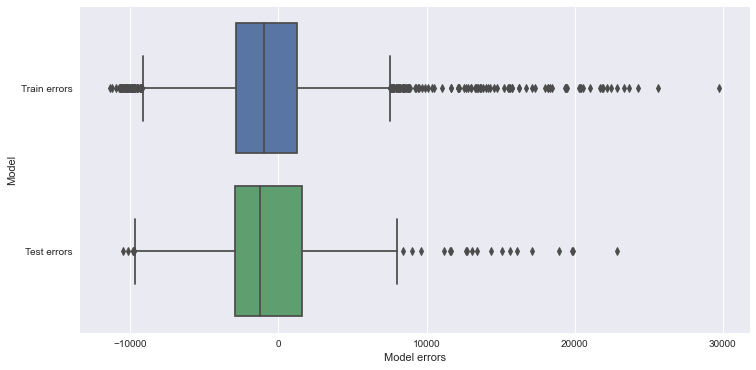

In [81]:
#Визуализируем ошибки
fig, ax = plt.subplots(figsize=(12, 6)) #фигура + координатная плоскость
#Ошибки модели
y_errors_train = y_train - y_train_predict
y_errors_test = y_test - y_test_predict
#Для удобства визуализации составим DataFrame из ошибок
errors_df = pd.DataFrame(
    {'Train errors': y_errors_train,
     'Test errors': y_errors_test
    }
)
#Строим boxplot для ошибок
sns.boxplot(data=errors_df, orient='h', ax=ax)
ax.set_xlabel('Model errors') #название оси абсцисс
ax.set_ylabel('Model'); #название оси ординат

Выводы:    
1. Разброс ошибок на тренировочной выборке больше, чем на тестовой.    
2. Медианная ошибка на тренировочной и тестовой выборках отрицательная (меньше 0).

## Итерация №2

Нормализация тренировочной и тестовой выборок

In [68]:
#Создаем объект для min-max нормализации
scaler = preprocessing.MinMaxScaler()
#Вычисляем параметры для нормализации - min и max для каждого столбца
scaler.fit(X_train)
#Производим преобразование для каждой из выборок
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Генерация полиномиальных признаков степени 2

In [72]:
#Создаем объект для генерации полиномиальных признаков степени 2
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
#Вычисляем параметры генерации - результирующее количество признак
poly.fit(X_train_scaled)
#Производим преобразование для каждой из выборок
X_train_scaled_poly = poly.transform(X_train_scaled)
X_test_scaled_poly = poly.transform(X_test_scaled)

Задание 6.5. Чему равно результирующее количество столбцов?

In [73]:
print('Train shape: {}'.format(X_train_scaled_poly.shape))
print('Test shape: {}'.format(X_test_scaled_poly.shape))

Train shape: (1070, 54)
Test shape: (268, 54)


### Моделирование

In [82]:
#Создаём объект класса LinearRegression
lr_poly = linear_model.LinearRegression()
#Обучаем модель по МНК
lr_poly.fit(X_train_scaled_poly, y_train)

#Делаем предсказание для выборок
y_train_predict_poly = lr_poly.predict(X_train_scaled_poly)
y_test_predict_poly = lr_poly.predict(X_test_scaled_poly)

### Оценка модели

Задание 6.6. Чему равно значение метрики R^2 на тестовой выборке?

In [77]:
get_metrics(y_train, y_train_predict_poly, y_test, y_test_predict_poly)

Train R^2: 0.842
Train MAE 2917
Train MAPE 30


Test R^2 score: 0.866
Test MAE 2764
Test MAPE 31


Задание 6.7. Вывести значения коэффициентов полученной модели, провести анализ

In [84]:
print(lr_poly.coef_)

[-3.71105135e+16  2.90624807e+17 -7.81502356e+15  1.52571599e+15
 -8.85674845e+15 -2.58845363e+16 -1.77612957e+17 -7.20024939e+16
 -4.46806128e+16  8.37600000e+03  7.86000000e+02  8.52000000e+02
 -1.84000000e+03  2.16000000e+02  3.71105135e+16  3.71105135e+16
  3.71105135e+16  3.71105135e+16 -2.48025958e+17  7.78000000e+02
 -1.30387500e+03  3.59125000e+02 -4.25988491e+16 -4.25988491e+16
 -4.25988491e+16 -4.25988491e+16 -9.53775000e+03  1.68771875e+03
  5.49247656e+04  7.81502356e+15  7.81502356e+15  7.81502356e+15
  7.81502356e+15 -2.08000000e+03 -2.25000000e+03 -1.52571599e+15
 -1.52571599e+15 -1.52571599e+15 -1.52571599e+15 -2.35115674e+16
  3.23683159e+16  3.23683159e+16  3.23683159e+16  3.23683159e+16
 -3.73724177e+16  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.14356003e+17  0.00000000e+00  0.00000000e+00  8.74553994e+15
  0.00000000e+00 -1.85763413e+16]


Вывод:    
Значения коэффициентов очень высокие, модель неустойчива, необходима регуляризация. 

## Итерация №3

Решение проблемы огромных значений коэффициентов - использование регуляризации

### Моделирование

**Линейная регрессия с L1-регуляризацией**

In [88]:
#Создаём объект класса линейной регрессии с L1-регуляризацией
lasso_lr_poly = linear_model.Lasso(max_iter = 2000)
#Обучаем модель
lasso_lr_poly.fit(X_train_scaled_poly, y_train)

#Делаем предсказание для выборок
y_train_predict_poly = lasso_lr_poly.predict(X_train_scaled_poly)
y_test_predict_poly = lasso_lr_poly.predict(X_test_scaled_poly)

### Оценка модели

Задание 6.8. Чему равны метрики на тестовой выборке?

In [90]:
get_metrics(y_train, y_train_predict_poly, y_test, y_test_predict_poly)

Train R^2: 0.839
Train MAE 2949
Train MAPE 30


Test R^2 score: 0.863
Test MAE 2861
Test MAPE 31


In [87]:
print(lasso_lr_poly.coef_)

[ 3.24221653e+03 -4.92313816e+02  5.07612317e+03  4.58362056e+03
  1.97928569e+03  1.88025707e+02 -4.70775218e+02  5.83657101e+02
 -2.43543456e+02  8.29826751e+03  7.74581954e+02  8.44448593e+02
 -1.20775688e+03  1.34809915e+02 -1.04309726e+03 -0.00000000e+00
  1.16964229e+03  1.61765564e+03 -0.00000000e+00  5.05847740e+02
 -1.13425152e+03  2.65796922e+02 -1.22240479e+03  0.00000000e+00
  2.36213242e+02 -5.80031340e+02 -8.17963257e+03  1.29487768e+03
  5.47148553e+04  3.58531873e+03  2.40690210e+03 -9.63549427e+02
  0.00000000e+00 -1.67464337e+03 -2.05436459e+03  1.94204864e+03
  1.95394442e+03 -0.00000000e+00 -1.06364416e+03  8.00606774e+00
  5.93688978e+02 -0.00000000e+00 -2.30643423e+02  1.97933477e+03
  6.31615519e+02  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -6.05849873e-01]


## Итерация №4

### Моделирование

**Линейная регрессия с L2-регуляризацией**

In [89]:
#Создаём объект класса линейной регрессии с L2-регуляризацией
ridge_lr_poly = linear_model.Ridge()
#Обучаем модель
ridge_lr_poly.fit(X_train_scaled_poly, y_train)

#Делаем предсказание для выборок
y_train_predict_poly = ridge_lr_poly.predict(X_train_scaled_poly)
y_test_predict_poly = ridge_lr_poly.predict(X_test_scaled_poly)

### Оценка модели

Задание 6.9. Чему равны метрики на тестовой выборке?

In [91]:
get_metrics(y_train, y_train_predict_poly, y_test, y_test_predict_poly)

Train R^2: 0.839
Train MAE 2949
Train MAPE 30


Test R^2 score: 0.863
Test MAE 2861
Test MAPE 31


In [92]:
print(ridge_lr_poly.coef_)

[ 3369.38386245  -457.59604061  3655.82413935  3198.89989857
  2682.62197133   199.05715111  -228.717235     191.94660928
  -162.28652539  7548.51142058   581.66782381   935.50427948
  -681.52086519   663.45387027  -450.92174702   438.63623056
  1406.72601433  1974.94336458  -457.59604061   947.62267378
  -902.74408745   739.02044241  -822.63208356   302.52583364
   351.60830856  -289.09809926 -4274.11806366  2734.55631801
 44541.21377369  3667.33801864  1719.64618126 -1249.79159857
  -481.36846198 -1314.96604775 -2172.72264458  2171.5603185
  1997.18187938   112.64828732 -1082.49058663  2682.62197133
    94.23317954  -208.05994803   535.71682279  2260.73191704
   199.05715111     0.             0.             0.
  -228.717235       0.             0.           191.94660928
     0.          -162.28652539]
